# Radioactive decay ☢️

In this demo, we will learn how to set radioactive decay in a FESTIM model.

We will set a simple 1D model with one trap.

The sample will be at 300 K and exposed to tritium for a half a year.

After that, the source of tritium will be turned off and the sample will be stored for several half-lives (about 12 years).

## FESTIM model

In [1]:
import festim as F
import numpy as np
import sympy as sp

my_model = F.Simulation()

vertices = np.concatenate(
    [
        np.linspace(0, 2e-5, num=1000),
        np.linspace(2e-5, 1e-4, num=300),
        np.linspace(1e-4, 1e-2, num=100),
    ]
)
my_model.mesh = F.MeshFromVertices(vertices)

my_model.materials = F.Material(id=1, D_0=1e-7, E_D=0.2)

my_model.traps = F.Trap(
    k_0=1e-16,
    E_k=0.2,
    p_0=1e13,
    E_p=1.2,
    density=1.3e24,
    materials=my_model.materials[0],
)

exposure_time = 2e7
my_model.boundary_conditions = [
    F.DirichletBC(
        surfaces=[1],
        value=sp.Piecewise((1e17, F.t < exposure_time), (0, True)),
        field="solute",
    )
]


my_model.T = 300

Radioactive decay is implemented as a volumetric source in FESTIM.
The ``RadioactiveDecay`` class takes a decay constant as argument as well as a volume (here there is only one) and a field to which the source is applied.

By default, ``field`` is set to ``"all"`` but it is also possible to set it only for some species.

In [2]:
half_life = 12 * 365 * 24 * 3600  # 12 years
decay_constant = np.log(2) / half_life

my_model.sources = [
    F.RadioactiveDecay(decay_constant=decay_constant, volume=1, field="all"),
]

We then set some derived quantities exports as well as profile exports:

In [3]:
derived_quantities = F.DerivedQuantities(
    [
        F.TotalVolume("retention", volume=1),
        F.TotalVolume("solute", volume=1),
        F.TotalVolume("1", volume=1),
    ],
    show_units=True,
)
txt_export = F.TXTExport(
    "retention",
    times=[
        exposure_time,
        exposure_time + 1 * half_life,
        exposure_time + 2 * half_life,
        exposure_time + 3 * half_life,
    ],
    filename="task11/profiles.txt",
)

my_model.exports = [derived_quantities, txt_export]

The simulation will go on for three half-lives after the exposure.

In [4]:
my_model.dt = F.Stepsize(
    initial_value=1e3, stepsize_change_ratio=1.1, milestones=txt_export.times
)

my_model.settings = F.Settings(
    absolute_tolerance=1e6,
    relative_tolerance=1e-10,
    final_time=exposure_time + 3 * half_life,
    traps_element_type="DG",
)

my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.2e+09 s    Elapsed time so far: 12.5 s


## Results

We can plot the total inventory as a function of time. After the exposure, the inventory decreases as a geometric law expected from the 12 years half-life of tritium.

/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Text(0, 0.5, 'Inventory (T/m$^{2}$)')

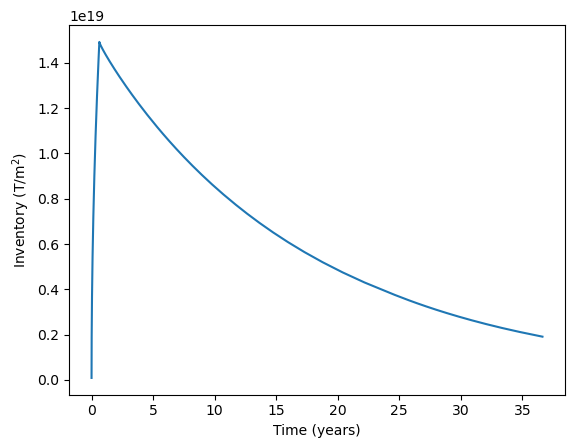

In [5]:
import matplotlib.pyplot as plt

time = np.array(derived_quantities[0].t)
retention = derived_quantities[0].data

solute = derived_quantities[1].data
trapped = derived_quantities[2].data
one_year = 365 * 24 * 3600
plt.plot(time / one_year, retention)
plt.xlabel("Time (years)")
plt.ylabel("Inventory (T/m$^{2}$)")

By plotting the retention profiles, we also observe the decrease of the tritium concentration.

Text(0, 0.5, 'Retention (T m$^{-3}$)')

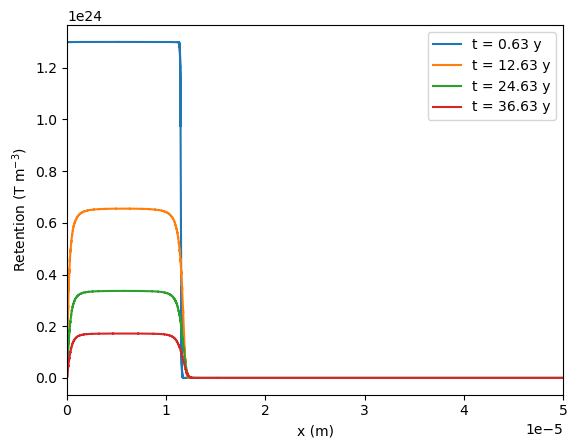

In [6]:
data = np.genfromtxt("task11/profiles.txt", delimiter=",", names=True)

for time in my_model.exports[1].times:
    name = f"t={time:.2e}s"
    name_clean = name.translate(str.maketrans("", "", "+.="))
    plt.plot(data["x"], data[name_clean], label=f"t = {time/one_year:.2f} y")

plt.legend()
plt.xlim(0, 5e-5)
plt.xlabel("x (m)")
plt.ylabel("Retention (T m$^{-3}$)")